<h2 style="color:green;">Distributed ranking plot computations with new impacts methods</h2>

As of demo day #8 (04.04.2025), this demonstration requires a custom branch of `cabinetry`, which can be pulled with 
```
pip install git+https://github.com/MoAly98/cabinetry.git@maly-issue-442
```

and your environment should force install the `main` branch of `pyhf`
```
pip install git+https://github.com/scikit-hep/pyhf.git@main
```

First create N-tuples to use for this example 

In [1]:
!python create_ntuples.py

<h3 style="color:green;"> The new impacts methods</h3>

Load the cabinetry config and review the content

In [2]:
import logging
import shutil

import cabinetry
logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)
import pyhf


shutil.rmtree("histograms", ignore_errors=True)

# import example config file
config = cabinetry.configuration.load("config_example.yml")
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file config_example.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


Produce the required template histograms and run post-processing

In [3]:
# create template histograms
cabinetry.templates.build(config)

# perform histogram post-processing
cabinetry.templates.postprocess(config)

WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]


Create workspace, build model and run fit

In [4]:
# build a workspace
ws = cabinetry.workspace.build(config)
# produce model and extract data
model, data = cabinetry.model_utils.model_and_data(ws)
parameters_list = model.config.par_names
model_spec = model.spec
# run the fit
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.workspace - building workspace
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└────────────────────

We check the fit model looks correct

INFO - cabinetry.visualize.utils - saving figure as simple_example/data_mc/Signal_region_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as simple_example/data_mc/Signal_region_postfit.pdf


[{'figure': <Figure size 600x600 with 2 Axes>, 'region': 'Signal_region'}]

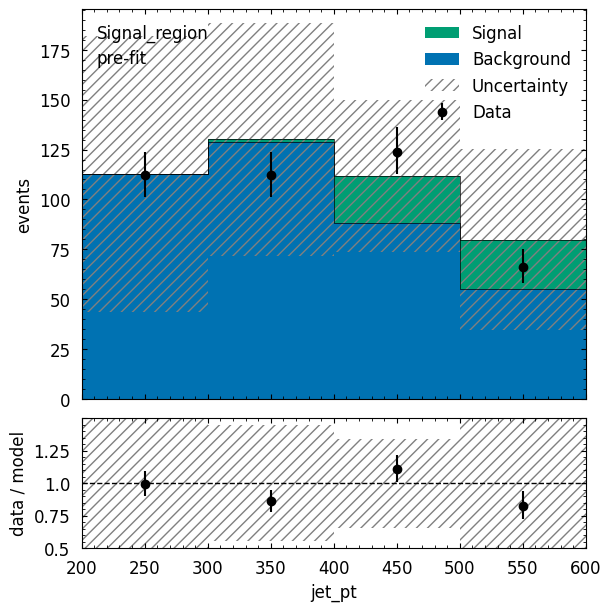

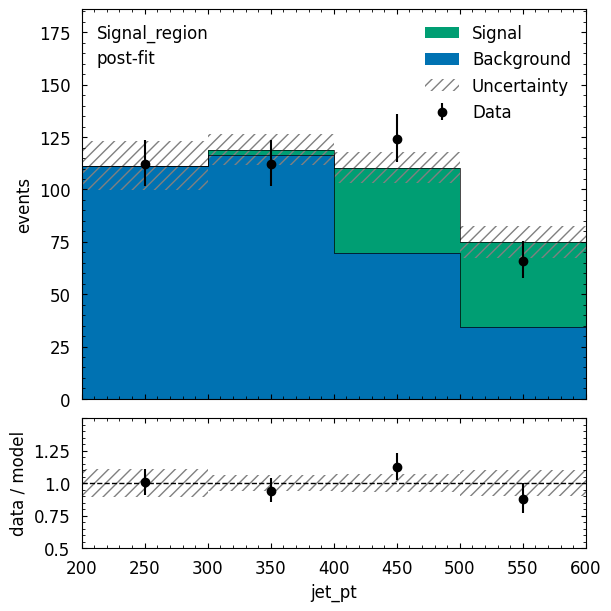

In [5]:
# visualize the pre-fit model prediction and data
prediction_prefit = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(prediction_prefit, data, config=config, figure_folder="simple_example/data_mc/")

# visualize the post-fit model prediction and data
prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
cabinetry.visualize.data_mc(prediction_postfit, data, config=config, figure_folder="simple_example/data_mc/")

Check what the nuisance parameter pulls look like

INFO - cabinetry.visualize.utils - saving figure as simple_example/pulls/pulls.pdf


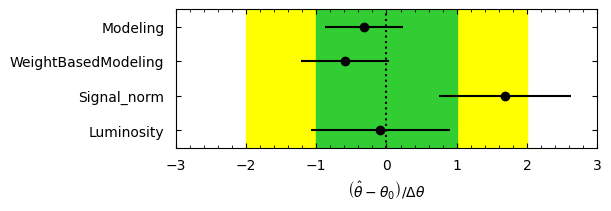

In [6]:
cabinetry.visualize.pulls(
    fit_results, close_figure=True, save_figure=True, figure_folder="simple_example/pulls/"
)

Now we want to run our ranking computations, and we have a choice of which method to use via the `impacts_method` argument in `cabinetry.fit.ranking`

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.35                      │              Nfcn = 269              │
│ EDM = 2.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────

CPU times: user 1.57 s, sys: 33.4 ms, total: 1.6 s
Wall time: 828 ms


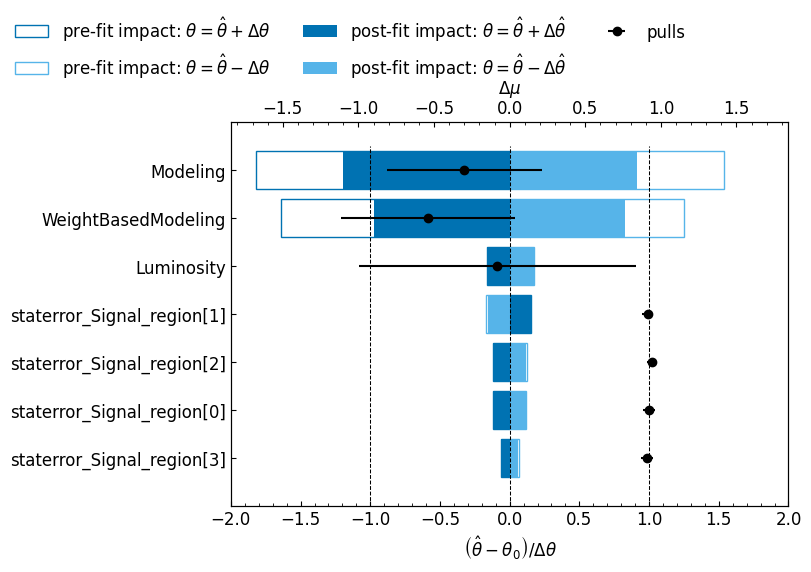

In [7]:
%%time
# Run ranking with the NP-shifting method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="np_shift")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_example/serial_rankings/")

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - calculating impact of WeightBasedModeling on Signal_norm
INFO - cabinetry.fit - calculating impact of Luminosity on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[0] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[1] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[2] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[3] on Signal_norm
INFO - cabinetry.visualize.utils - saving figure as simple_example/serial_rankings/ranking_covariance.pdf


CPU times: user 471 ms, sys: 20 ms, total: 491 ms
Wall time: 192 ms


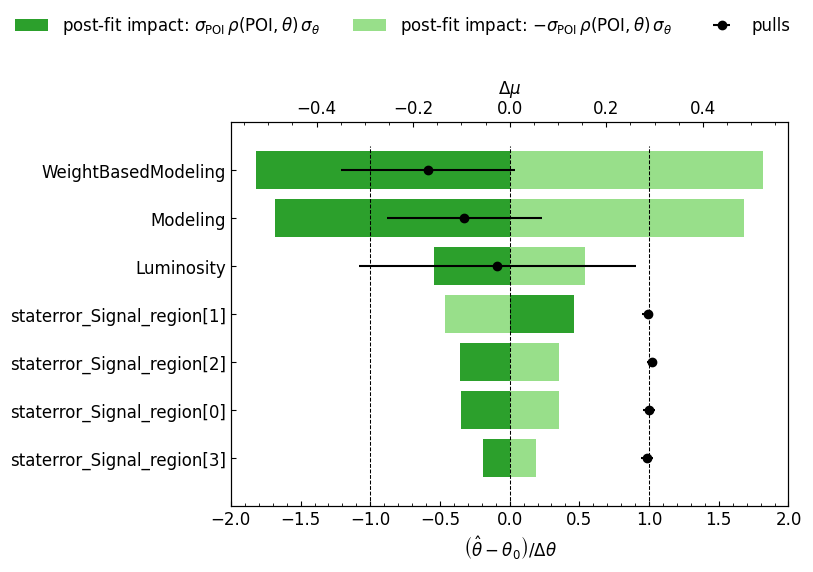

In [8]:
%%time
# Run ranking with covariance-based method: this is the default method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="covariance")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_example/serial_rankings/")

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.58                      │              Nfcn = 291              │
│ EDM = 4.85e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────

CPU times: user 1.07 s, sys: 21.8 ms, total: 1.09 s
Wall time: 546 ms


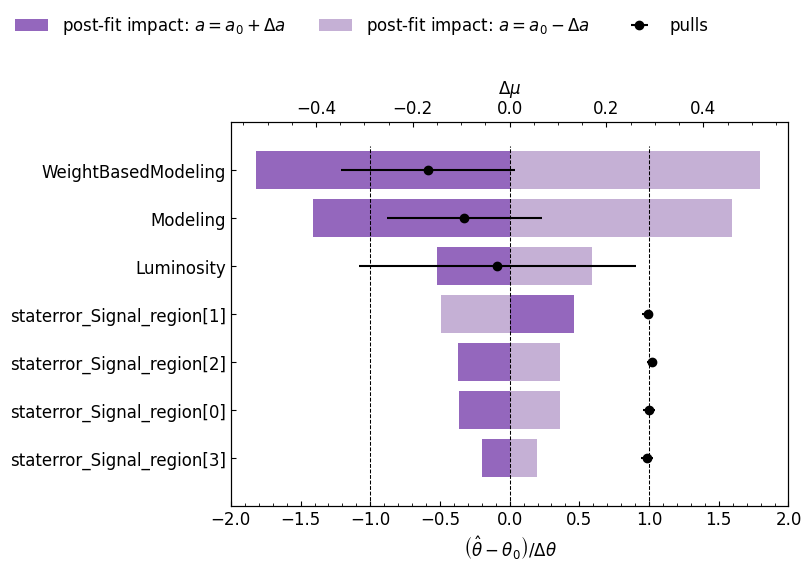

In [9]:
%%time
# Run ranking with covariance-based method: this is the default method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="auxdata_shift")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_example/serial_rankings/")

<h3 style="color:green;">Distributed ranking computation </h3>

Ranking is very computationally intensive in the NP-shifting and Auxiliary data-shifting methods. For this simple configuration, we don't feel it, but for larger models (e.g. 100 of parameters), the single-fit time increases, the number of fits required explodes, a ranking can take days to run sequentially.

Current `cabinetry` implementation of the ranking function does not allow for any form of parallelisation without the user having to re-write elements of the function themselves.
In this next part of the notebook, we demonstrate that there is now: 
- an infrastructure for the user to parallelise calls to the ranking function (4 fits at a time (NP) or 2 fits at a time (AUX))
- an API to get a maximal distribution of individual ranking fits on a cluster via a `dask` client

To run this part, `dask.distributed` is needed in the environment. You should run
```
pip install dask[distributed]
``` 

Note that, in production, `dask` will be an optional dependency in `cabinetry`

<h4 style="color:green;"> Set up dask client </h4>

In [10]:
import time
from dask.distributed import Client, LocalCluster, PipInstall

COFFEA_CASA = False

def get_client(n_workers=4):
    if not COFFEA_CASA:
        cluster = LocalCluster(n_workers=n_workers, processes=True, threads_per_worker=1)
        client = Client(cluster)
        print(f"Dask dashboard: {cluster.dashboard_link}")
    else:
        dependencies = [
            "git+https://github.com/MoAly98/cabinetry.git@maly-issue-442",
        ]
        client = Client("tls://localhost:8786")
        client.register_plugin(PipInstall(packages=dependencies))
        cluster = None  # no local cluster in this mode
    return cluster, client

def close_client(cluster, client):
    if client:
        client.close()
    if cluster:
        cluster.close()
    return None, None

<h4 style="color:green;"> Parallelising ranking calls </h4>

The ranking function now accepts a list of parameters for which the ranking should be computed. This option can be used to call the ranking function for one parameter at-a-time, and evaluate them in parallel on a cluster.

In [11]:
def serialize_fit_results(fit_results):
    return {
        "bestfit": fit_results.bestfit.tolist(),
        "uncertainty": fit_results.uncertainty.tolist(),
        "labels": list(fit_results.labels),
        "corr_mat": fit_results.corr_mat.tolist(),
        "best_twice_nll": float(fit_results.best_twice_nll),
    }

def run_dask(func, cluster, client, model_spec, data, fit_results, parameters_list):
    fit_results_serialisable = serialize_fit_results(fit_results)
    try:
        futures = [
            client.submit(func, param, model_spec, data, fit_results_serialisable)
            for param in parameters_list
        ]
        return client.gather(futures)
    except (KeyboardInterrupt, Exception) as e:
        close_client(cluster, client)
        raise e

In [12]:
# Write the function that returns the workload to be distributed
# calls to this function are collected then distributed to the workers
# the use of model spec and a fit results dict is to avoid pickling the model and fit results
# which are not serliasable objects --> is there a better way?
def get_ranking_function(param, model_spec, data, fit_results_serialisable, method="auxdata_shift"):
    fit_results_int = cabinetry.model_utils.FitResults(**fit_results_serialisable)
    model_int = pyhf.Model(model_spec)
    return cabinetry.fit.ranking(
        model_int, data,
        fit_results=fit_results_int,
        impacts_method=method,
        parameters_list=[param],
        poi_name="Signal_norm",
    )

In [13]:
# Setup and run
test_n_workers = range(1,5,1)
for n_workers in test_n_workers:
    cluster, client = get_client(n_workers=n_workers)
    start = time.time()
    try:
        individual_ranking_results = run_dask(
            get_ranking_function,
            cluster,
            client,
            model_spec,
            data,
            fit_results,
            parameters_list[:10]
        )
        elapsed = time.time() - start
        n_workers = len(client.scheduler_info()['workers'])
        print(f"Elapsed for {n_workers} workers: {elapsed:.2f} seconds")
    finally:
        cluster, client = close_client(cluster, client)

Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 1 workers: 1.12 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 2 workers: 0.95 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 3 workers: 0.91 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 4 workers: 0.83 seconds


Now that we  have the results from individual ranking calls, we need to combine them and plot! We implemented a utility to allow a user to do this combination quickly and pass the result to plotting functions

INFO - cabinetry.visualize.utils - saving figure as simple_example/dask_rankings/ranking_auxdata_shift.pdf


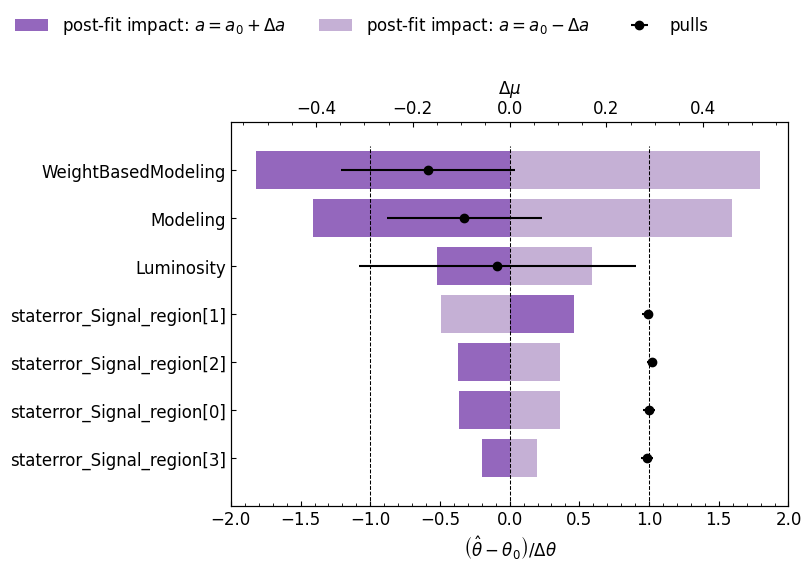

In [14]:
from cabinetry.fit.utils import collect_ranking_results
ranking_results = collect_ranking_results(individual_ranking_results)
cabinetry.visualize.ranking(
    ranking_results, close_figure=True, save_figure=True, figure_folder="simple_example/dask_rankings/", max_pars=10
)

The fit is too fast right now to see the benefit given the `dask` overhead, so let's add some delay to see the difference between the serial and distirbuted code

In [ ]:
def get_delayed_ranking_function(param, model_spec, data, fit_results_serialisable, method="auxdata_shift"):
    fit_results_int = cabinetry.model_utils.FitResults(**fit_results_serialisable)
    model_int = pyhf.Model(model_spec)
    time.sleep(5)
    return cabinetry.fit.ranking(
        model_int, data,
        fit_results=fit_results_int,
        impacts_method=method,
        parameters_list=[param],
        poi_name="Signal_norm"
    )

test_n_workers = range(4)
for n_workers in test_n_workers:
    cluster, client = get_client(n_workers=n_workers)

    start = time.time()
    try:
        individual_ranking_results = run_dask(
            get_delayed_ranking_function,
            cluster,
            client,
            model_spec,
            data,
            fit_results,
            parameters_list[:10],
        )
        elapsed = time.time() - start
        n_workers = len(client.scheduler_info()['workers'])
        print(f"Elapsed for {n_workers} workers: {elapsed:.2f} seconds")
    finally:
        cluster, client = close_client(cluster, client)

Dask dashboard: http://127.0.0.1:8787/status


In [ ]:
ranking_results = cabinetry.fit.utils.collect_ranking_results(individual_ranking_results)
cabinetry.visualize.ranking(
    ranking_results, close_figure=True, save_figure=True, figure_folder="simple_example/dask_delayed_rankings/", max_pars=10
)

<h4 style="color:green;"> Parallelising fit calls </h4>

The user can instead choose to let cabinetry handle the parallelisation for them by passing a dask client to the ranking funciton call. Behind the scenes, cabinetry will collect individual calls to the **fit** function, and then submit them to the cluster through the client

In [ ]:
def delayed_paralle_ranking_function(parameters_list, model_spec, data, fit_results_serialisable, method="auxdata_shift"):
    time.sleep(5)
    return cabinetry.fit.ranking(
        model,
        data,
        fit_results=fit_results,
        impacts_method="auxdata_shift",
        parameters_list=parameters_list,
        client=client
    )

test_n_workers = [2]
for n_workers in test_n_workers:
    cluster, client = get_client(n_workers=n_workers)
    start = time.time()
    try:
        ranking_result_auxdata_shift = delayed_paralle_ranking_function(
            parameters_list,
            model_spec,
            data,
            serialize_fit_results(fit_results),
            method="auxdata_shift",
        )
        elapsed = time.time() - start
        n_workers = len(client.scheduler_info()['workers'])
        print(f"Elapsed for {n_workers} workers: {elapsed:.2f} seconds")
    finally:
        cluster, client = close_client(cluster, client)

In [ ]:
cabinetry.visualize.ranking(
    ranking_result_auxdata_shift, close_figure=True, save_figure=True, figure_folder="simple_example/dask_rankings_by_fit/", max_pars=10
)